In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np, os
from mantid import simpleapi as msa, mtd

Run # 130260, Vanadium 5x5cm2, Ei=55 meV, F2=420 Hz, T0=90 Hz, PC=3 C

Read data

In [3]:
w = msa.Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130260.nxs.h5', LoadMonitors=True)

In [4]:
mons = w[1]
w = w[0]

Get Ei, vi

In [5]:
Ei, T0 = msa.GetEiT0atSNS(mons)

In [6]:
Ei, T0

(55.46598187461831, 43.72705035409854)

In [7]:
vi = 437.4*np.sqrt(Ei)
vi

3257.5578083027858

Get L1, t1

In [8]:
instr = w.getInstrument()

In [9]:
print instr.getSource().getPos()
print instr.getSample().getPos()

[0,0,-20.0114]
[0,0,0]


In [10]:
L1 = (instr.getSample().getPos() - instr.getSource().getPos())[-1]

In [11]:
L1

20.0114

In [12]:
t1 = L1/vi*1e6
t1

6143.0682669684074

To histogram

In [13]:
msa.Rebin(InputWorkspace=w, OutputWorkspace=w, Params="0,1.,16667")

EventWorkspace
Title: Vanadium 5x5cm2, Ei=55meV F2=420 T0=90
Histograms: 115712
Bins: 16667
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: SEQUOIA (2012-Apr-04 to 2100-Jan-31)Instrument from: /SNS/SEQ/IPTS-19573/nexus/SEQ_130260.nxs.h5

Parameters from: /home/lj7/dv/mantid/mantid/instrument/SEQUOIA_Parameters.xml
Run start: 2017-Jul-13 05:38:47
Run end:  2017-Jul-13 06:39:48

Events: 24081998

Nominal L2

In [14]:
L2 = np.linalg.norm(instr.getDetector(40000).getPos())
L2

5.5248554772882894

In [15]:
(L1+L2)/vi * 1e6 + T0

7882.8068088781329

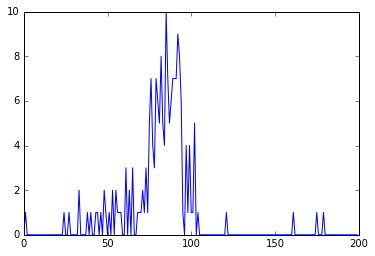

In [16]:
plt.plot(w.readY(40000)[7800:8000])

Simple estimate of peak position

In [17]:
t = np.argmax(w.readY(40000))
t

7885

In [18]:
t2 = t - t1 - T0
t2

1698.204682677494

In [19]:
d = t2*vi/1e6
d

5.5319999241524256

Pretty close

In [20]:
print d, L2

5.53199992415 5.52485547729


Better estimate of peak position

In [26]:
tof_0 = (L1+L2)/vi * 1e6 + T0
print tof_0

7882.80680888


In [25]:
spectrum_number = 40000
spectrum = w.readY(spectrum_number)
center_bin = int(tof_0)
subset = spectrum[center_bin-100: center_bin+100]
center = np.dot(subset, np.arange(center_bin-100+.5, center_bin+100+.5))/np.sum(subset)
print center

7881.26190476


In [27]:
t = center
print (t - t1 - T0)*vi/1e6, L2

5.51982286282 5.52485547729


# Now go through all pixels

In [28]:
N = w.getNumberHistograms()

In [29]:
def iterL2(min_counts=20):
    for i in range(N):
        if i%10000==0: print i
        sp = w.getSpectrum(i)
        pixelID = sp.getDetectorIDs()[0]
        spectrum = w.readY(i)
        nominal_L2 = np.linalg.norm(instr.getDetector(pixelID).getPos())
        tot_counts = np.sum(spectrum)
        if tot_counts == 0:
            yield i, pixelID, nominal_L2, -1, tot_counts # dets not installed
            continue
        nominal_TOF = (L1+nominal_L2)/vi * 1e6 + T0
        center_bin = int(nominal_TOF)
        subset = spectrum[center_bin-100: center_bin+100]
        center = np.dot(subset, np.arange(center_bin-100+.5, center_bin+100+.5))/np.sum(subset)
        t = center
        L2 = (t - t1 - T0)*vi/1e6
        # assert abs(nominal_L2-L2)/nominal_L2<0.1
        yield i, pixelID, nominal_L2, L2, tot_counts
        continue

In [30]:
%%time
L2s = list(iterL2(min_counts=1))

0
10000
20000
30000
40000
50000
60000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


70000
80000
90000
100000
110000
CPU times: user 23.9 s, sys: 2.68 s, total: 26.6 s
Wall time: 26.5 s


In [31]:
#Debug code:
#for spectrumNo, pixelID, L2_0, L2, tot_counts in L2s:
#    if L2 < 0: continue
#    if L2 == 0 or abs(L2_0-L2)/L2_0 > 0.01:
#        print spectrumNo, pixelID, L2_0, L2, tot_counts

In [32]:
#Debug code:
#L2s[:10]

In [33]:
L2table = msa.CreateEmptyTableWorkspace()

In [34]:
%%time
L2table.addColumn(type='int', name='detid')
L2table.addColumn(type='float', name="L2")
L2table.addColumn(type='int', name="nodata")

for spectrumNo, pixelID, L2_0, L2, tot_counts in L2s:
    row = dict(detid=pixelID, L2=L2, nodata=int(L2<0))
    L2table.addRow(row)

CPU times: user 432 ms, sys: 48 ms, total: 480 ms
Wall time: 445 ms


In [35]:
msa.SaveNexus(L2table, 'L2table.nxs')